In [10]:
import utils
from preprocessing import *
SIZE = 256

In [102]:
img_train, mask_train = prepareDataset(TRAIN_CONTOUR_PATH, TRAIN_IMG_PATH)
img_test, mask_test = prepareDataset(TEST_CONTOUR_PATH, TEST_IMG_PATH)
img_val, mask_val = prepareDataset(VAL_CONTOUR_PATH, VAL_IMG_PATH)

ROI_train = get_ROI(TRAIN_CONTOUR_PATH)
ROI_test = get_ROI(TEST_CONTOUR_PATH)
ROI_val = get_ROI(VAL_CONTOUR_PATH)

Number of examples: 260

Processing 260 images and labels ...

Number of examples: 279

Processing 279 images and labels ...

Number of examples: 266

Processing 266 images and labels ...



In [38]:
img_tv = np.concatenate((img_train, img_val), axis = 0)
roi_tv = np.concatenate((ROI_train, ROI_val), axis = 0)
print(img_tv.shape)
print(roi_tv.shape)

(526, 256, 256, 1)
(526, 32, 32)


In [39]:
def reformDataXY(img, ROI, img_size = 64,  mask_size = 32):
    X = np.zeros((img.shape[0], img_size, img_size, 1))
    for i in range(X.shape[0]):
        X[i,:,:,0] = cv2.resize(img[i,:,:,0], (img_size, img_size), interpolation = cv2.INTER_LINEAR)
    Y = np.array(ROI).reshape((len(ROI),1, mask_size, mask_size))
    return X, Y

In [62]:
X, Y = reformDataXY(img_tv, roi_tv)
X_test, Y_test = reformDataXY(img_test, ROI_test)

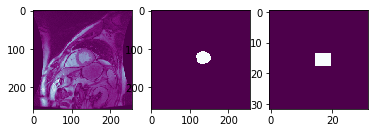

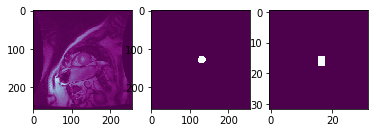

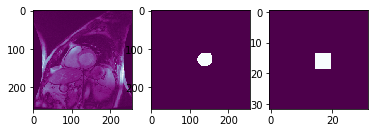

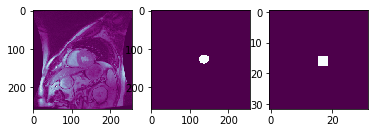

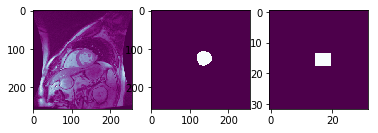

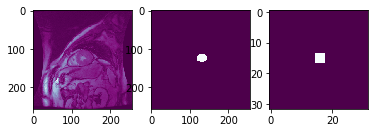

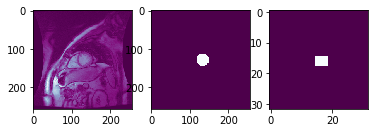

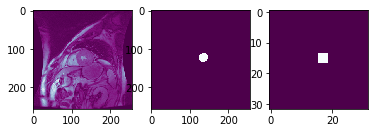

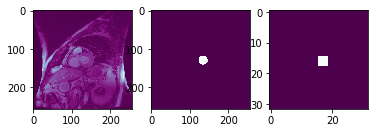

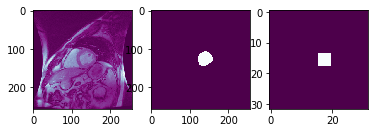

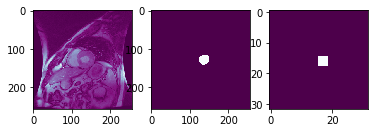

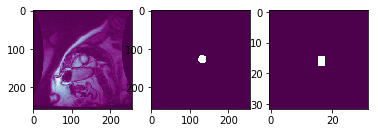

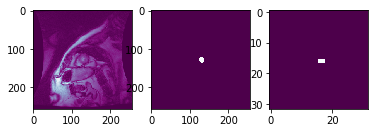

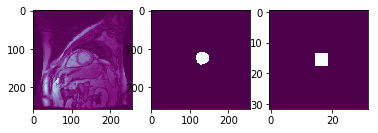

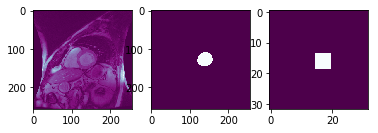

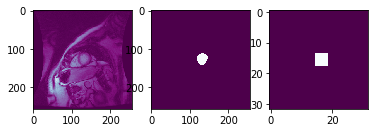

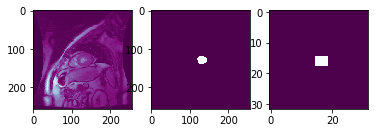

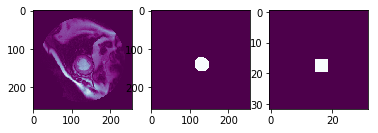

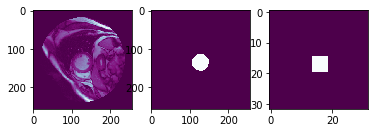

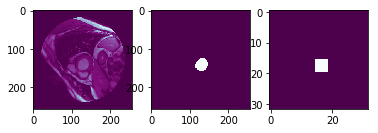

In [13]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
for i in range(20):
    mask = mask_train[i, :, :, 0]
    img = img_train[i, :, :, 0]
    plt.figure()
    plt.subplot(131)
    plt.imshow(img, cmap=plt.cm.BuPu_r)
    plt.subplot(132)
    plt.imshow(mask, cmap=plt.cm.BuPu_r)
    plt.subplot(133)
    plt.imshow(ROI_train[i],cmap=plt.cm.BuPu_r)

(526, 64, 64, 1)
(526, 1, 32, 32)


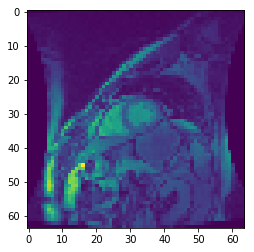

In [43]:
print(X.shape)
print(Y.shape)
plt.imshow(X[0,:,:,0])

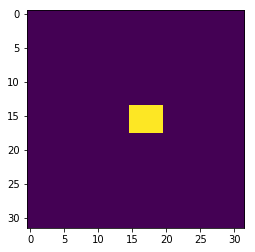

In [17]:
plt.imshow(Y[0,0,:,:])

In [55]:
from baseline_model import *
model = create_model()

Size for each layer :
Layer, Input Size, Output Size
('Conv2D_4', (None, 64, 64, 1), (None, 54, 54, 100))
('Average_Pooling2D_4', (None, 54, 54, 100), (None, 9, 9, 100))
('Reshape_7', (None, 9, 9, 100), (None, 1, 8100))
('Dense_4', (None, 1, 8100), (None, 1, 1024))
('Reshape_8', (None, 1, 1024), (None, 1, 32, 32))


In [61]:
model.compile(loss='mean_absolute_error',
              optimizer='adam',
              metrics=['accuracy'])
h = training(model, X, Y, batch_size=16, epochs= 10, data_augm=False)

Epoch 1/10
526/526 [==============================] - 8s 15ms/step - loss: 0.0184 - acc: 0.0467
Epoch 2/10
526/526 [==============================] - 7s 14ms/step - loss: 0.0199 - acc: 0.0526
Epoch 3/10
526/526 [==============================] - 7s 14ms/step - loss: 0.0247 - acc: 0.0548
Epoch 4/10
526/526 [==============================] - 7s 13ms/step - loss: 0.0297 - acc: 0.0472
Epoch 5/10
526/526 [==============================] - 7s 13ms/step - loss: 0.0322 - acc: 0.0363
Epoch 6/10
526/526 [==============================] - 7s 13ms/step - loss: 0.0317 - acc: 0.0348
Epoch 7/10
526/526 [==============================] - 8s 14ms/step - loss: 0.0303 - acc: 0.0371
Epoch 8/10
526/526 [==============================] - 7s 14ms/step - loss: 0.0285 - acc: 0.0362
Epoch 9/10
526/526 [==============================] - 7s 14ms/step - loss: 0.0267 - acc: 0.0418
Epoch 10/10
526/526 [==============================] - 7s 14ms/step - loss: 0.0258 - acc: 0.0493


In [63]:
y_pred = model.predict(X_test, batch_size = 16)

In [120]:
print(y_pred.shape)

(279, 1, 32, 32)


In [53]:
temp = y_pred[0,0,:,:]
temp = cv2.resize(temp.reshape((roi_shape, roi_shape)), (
                      256,256), cv2.INTER_NEAREST)
print(temp.shape)

(32, 32)


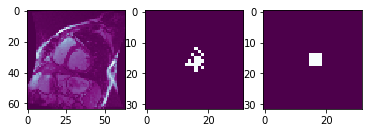

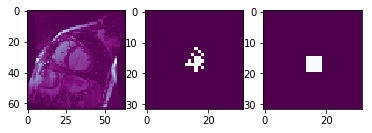

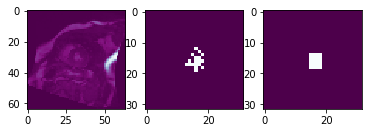

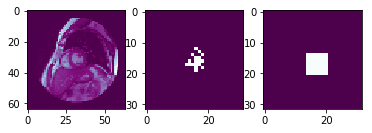

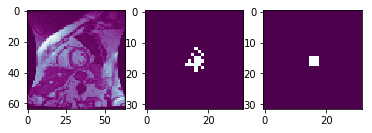

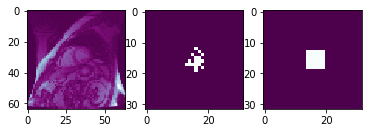

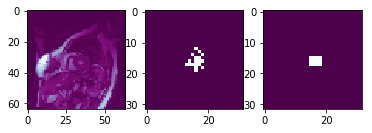

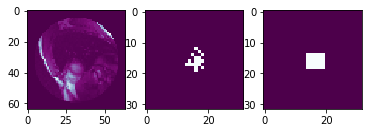

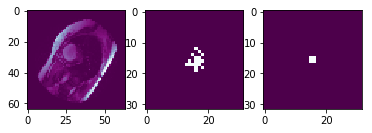

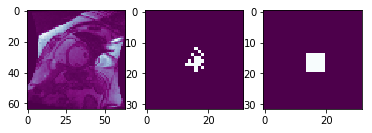

In [67]:
for i in range(10):
    mask = y_pred[i * 20, 0, :, :]
    img = X_test[i * 20, :, :, 0]
    plt.figure()
    plt.subplot(131)
    plt.imshow(img, cmap=plt.cm.BuPu_r)
    plt.subplot(132)
    plt.imshow(mask, cmap=plt.cm.BuPu_r)
    plt.subplot(133)
    plt.imshow(ROI_val[i],cmap=plt.cm.BuPu_r)

In [115]:
def get_cropped(img, y_pred, roi_size = 32, win_size = 100):
    n = img.shape[0]
    cropped = np.zeros((n, win_size, win_size, 1))
    for i in range(y_pred.shape[0]):
        pred = y_pred[i, 0, :,:]
        region = np.array(np.where(pred > 0.5))
        [x_median, y_median] = np.median(region, axis=1)
        x_median *= 256 / roi_size
        y_median *= 256 / roi_size
        x_min = int(max(0, x_median - win_size / 2))
        y_min = int(max(0, y_median - win_size / 2))
        x_max = x_min + win_size
        y_max = y_min + win_size
        cropped[i, :, :, 0] = img[i, x_min:x_max, y_min:y_max, 0]
    return cropped
     

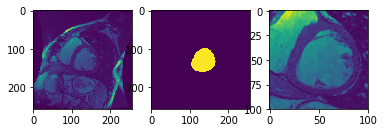

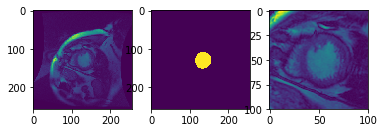

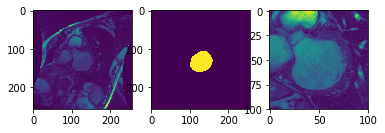

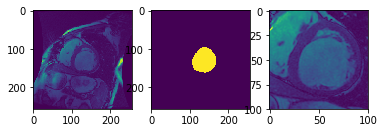

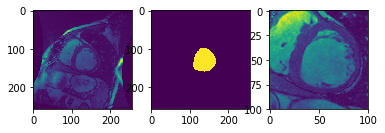

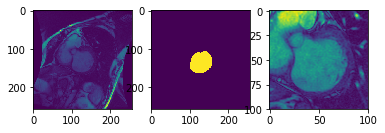

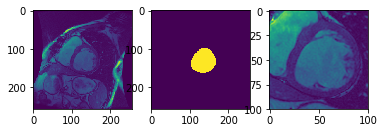

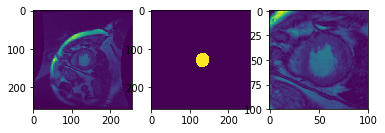

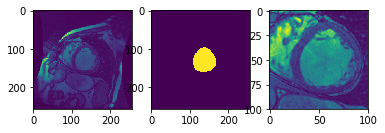

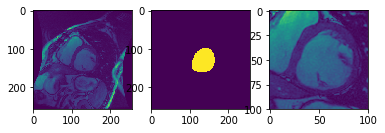

In [118]:
cropped = get_cropped(img_test, y_pred)
for i in range(10):
    plt.figure()
    plt.subplot(131)
    plt.imshow(img_test[i, :, :, 0])
    plt.subplot(132)
    
    plt.imshow(mask_test[i,:,:,0])
    plt.subplot(133)
    plt.imshow(cropped[i, :,:,0])